In [18]:
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from time import time
import pandas as pd
from sklearn.model_selection import train_test_split

In [75]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.ticker as ticker

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [70]:
class RandomForestMSE:
    def __init__(
        self, n_estimators, max_depth=None, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.trees_parameters = trees_parameters

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects
        """
        if self.feature_subsample_size is None:
            self.feature_subsample_size = X.shape[1] // 3
        self.models = []
        self.ind = []
        self.rmse = []
        self.rmse_test = []
        self.time = []
        start = time()
        predictions = np.zeros((y.shape))
        if y_val is not None:
            predictions_test = np.zeros((y_val.shape))
        for i in range(self.n_estimators):
            ind_features = np.random.choice(X.shape[1], size=self.feature_subsample_size, replace=False)
            ind_obj = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            model = DecisionTreeRegressor(max_depth=self.max_depth, **self.trees_parameters)
            model.fit(X[ind_obj,:][:, ind_features], y[ind_obj])
            self.models.append(model)
            self.ind.append(ind_features)
            pred_train = model.predict(X[:, ind_features])
            predictions += pred_train
            self.rmse.append((np.average((y - predictions/ (i + 1)) ** 2, axis=0)) ** 0.5)
            if X_val is not None:
                pred_test = model.predict(X_val[:, ind_features])
                predictions_test += pred_test
                self.rmse_test.append((np.average((y_val - predictions_test/ (i + 1)) ** 2, axis=0)) ** 0.5)               
            self.time.append(time() - start)  
            

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        res = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(X[:, self.ind[i]]))
        return np.mean(res, axis=0)

In [57]:
class GradientBoostingMSE:
    def __init__(
        self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use alpha * learning_rate instead of alpha

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.trees_parameters = trees_parameters
        
    

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects
        """
        def loss(alpha, prev, b, y):
            return ((prev + alpha * b - y) ** 2).sum()
        if self.feature_subsample_size is None:
            self.feature_subsample_size = X.shape[1] // 3
        self.models = []
        self.ind = []
        self.rmse = []
        self.rmse_test = []
        self.time = []
        self.alphas = []
        start = time()
        predictions = np.zeros((y.shape))
        if y_val is not None:
            predictions_test = np.zeros((y_val.shape))
        for i in range(self.n_estimators):
            ind_features = np.random.choice(X.shape[1], size=self.feature_subsample_size, replace=False)
            model = DecisionTreeRegressor(max_depth=self.max_depth, **self.trees_parameters)
            model.fit(X[:, ind_features], y - predictions)
            self.models.append(model)
            self.ind.append(ind_features)
            pred_train = model.predict(X[:, ind_features])
            cur_alpha = minimize_scalar(loss, args=(predictions, pred_train, y)).x
            self.alphas.append(cur_alpha)
            predictions += cur_alpha * self.learning_rate * pred_train
            self.rmse.append(np.average((y - predictions) ** 2, axis=0) ** 0.5)
            if X_val is not None:
                pred_test = model.predict(X_val[:, ind_features])
                predictions_test += cur_alpha * self.learning_rate * pred_test
                self.rmse_test.append(np.average((y_val - predictions_test) ** 2, axis=0) ** 0.5)               
            self.time.append(time() - start)
            

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        res = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(X[:, self.ind[i]]))
        return (np.array(res) * np.array(self.alphas)[:, None] ).sum(axis=0) * self.learning_rate

# Предобработка

In [9]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/kc_house_data.csv')

In [10]:
data['date'] = pd.to_datetime(data['date'])

In [11]:
data['year']=data['date'].dt.year 
data['month']=data['date'].dt.month 
data['day']=data['date'].dt.day

In [12]:
data = data.drop('date', axis=1)

In [13]:
data.head(3)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25


In [14]:
data = data.drop('id', axis=1)

In [15]:
y = data['price']
X = data.drop('price', axis=1)

In [16]:
X = X.to_numpy()
y = y.to_numpy()

In [24]:
model = RandomForestMSE(n_estimators=1000)
model.fit(X, y)

In [25]:
model.rmse[-1]

633252802.4600695

In [ ]:
model.rmse[-1]

57172.739390866285

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [71]:
model = RandomForestMSE(n_estimators=200)
model.fit(X_train, y_train, X_test, y_test)

In [72]:
model.rmse[-1]

58515.94654699626

In [73]:
model.rmse_test[-1]

145010.2668572382

In [58]:
gmodel = GradientBoostingMSE(n_estimators=300)
gmodel.fit(X_train, y_train, X_test, y_test)

In [59]:
gmodel.rmse[-1]

64305.81262093279

In [60]:
gmodel.rmse_test[-1]

112610.34632573198

# Исследование поведения случайного леса

In [117]:
model = RandomForestMSE(n_estimators=1000)
model.fit(X_train, y_train, X_test, y_test)

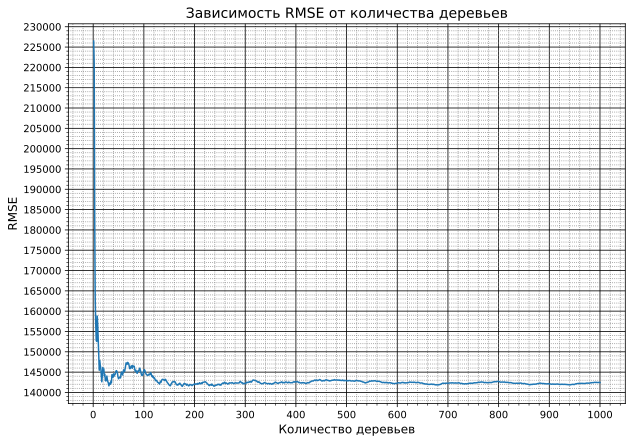

In [118]:
fig = plt.figure(figsize=(10,7))
plt.title('Зависимость RMSE от количества деревьев', fontsize=14)
plt.xlabel('Количество деревьев', fontsize=12)
plt.xticks([100 * i for i in range(11)])
plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(1000) + 1, model.rmse_test)
plt.savefig('RandomForest_trees_rmse.pdf', bbox_inches="tight")

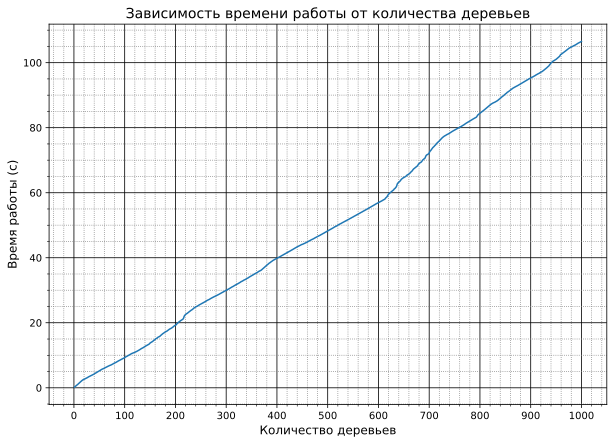

In [92]:
fig = plt.figure(figsize=(10,7))
plt.xlabel('Количество деревьев', fontsize=12)
plt.ylabel('Время работы (с)', fontsize=12)
plt.title('Зависимость времени работы от количества деревьев', fontsize=14)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.xticks([100 * i for i in range(11)])
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(1000) + 1, model.time)
plt.savefig('RandomForest_trees_time.pdf', bbox_inches="tight")

In [93]:
n_features = np.arange(21) + 1

In [126]:
rmse = []
times = []
for n_f in n_features:
    model = RandomForestMSE(n_estimators=200, feature_subsample_size=n_f)
    model.fit(X_train, y_train, X_test, y_test)
    rmse.append(model.rmse_test[-1])
    times.append(model.time[-1])

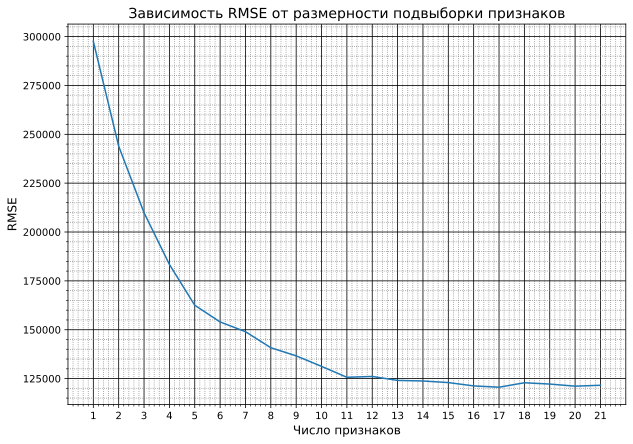

In [127]:
fig = plt.figure(figsize=(10,7))
plt.title('Зависимость RMSE от размерности подвыборки признаков', fontsize=14)
plt.xlabel('Число признаков', fontsize=12)
plt.xticks([i + 1 for i in range(21)])
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(n_features, rmse)
plt.savefig('RandomForest_feat_rmse.pdf', bbox_inches="tight")

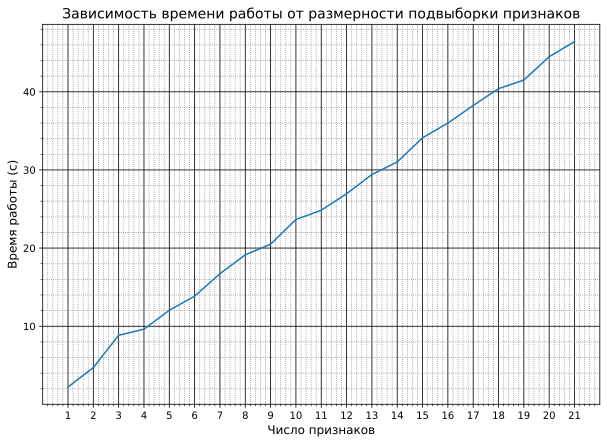

In [128]:
fig = plt.figure(figsize=(10,7))
plt.title('Зависимость времени работы от размерности подвыборки признаков', fontsize=14)
plt.xlabel('Число признаков', fontsize=12)
plt.xticks([i + 1 for i in range(21)])
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('Время работы (с)', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(n_features, times)
plt.savefig('RandomForest_feat_time.pdf', bbox_inches="tight")

In [139]:
depth = np.arange(20) + 1

In [140]:
rmse = []
times = []
for d in depth:
    model = RandomForestMSE(n_estimators=200, feature_subsample_size=13, max_depth=d)
    model.fit(X_train, y_train, X_test, y_test)
    rmse.append(model.rmse_test[-1])
    times.append(model.time[-1])

In [141]:
model = RandomForestMSE(n_estimators=200, feature_subsample_size=13)
model.fit(X_train, y_train, X_test, y_test)
rmse.append(model.rmse_test[-1])
times.append(model.time[-1])

In [142]:
depth = list(depth)
depth.append('None')

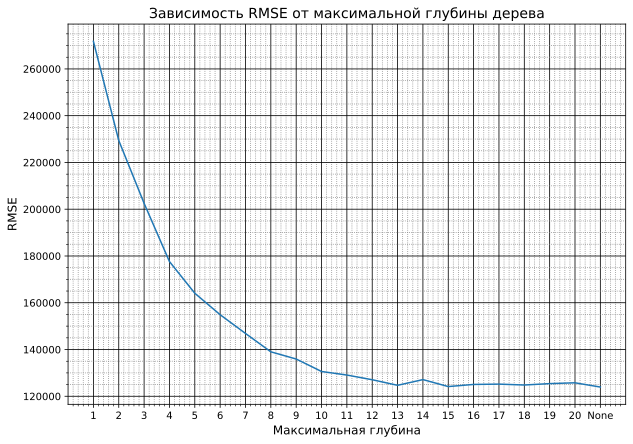

In [143]:
fig = plt.figure(figsize=(10,7))
plt.title('Зависимость RMSE от максимальной глубины дерева', fontsize=14)
plt.xlabel('Максимальная глубина', fontsize=12)
plt.xticks(ticks=(np.arange(21) + 1), labels=depth)
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(n_features, rmse)
plt.savefig('RandomForest_depth_rmse.pdf', bbox_inches="tight")

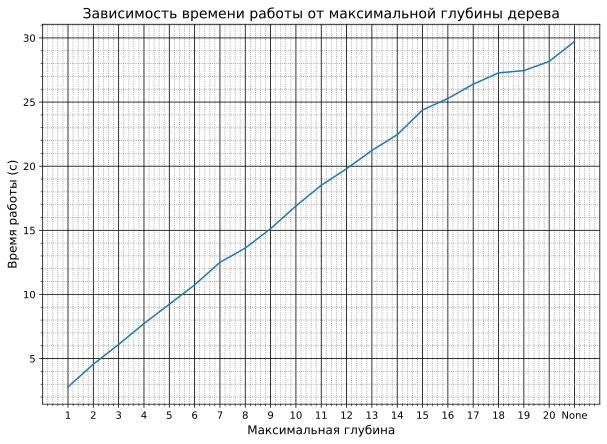

In [144]:
fig = plt.figure(figsize=(10,7))
plt.title('Зависимость времени работы от максимальной глубины дерева', fontsize=14)
plt.xlabel('Максимальная глубина', fontsize=12)
plt.xticks(ticks=(np.arange(21) + 1), labels=depth)
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('Время работы (с)', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(n_features, times)
plt.savefig('RandomForest_depth_time.pdf', bbox_inches="tight")

# Исследование поведения градиентного бустинга

In [113]:
gmodel = GradientBoostingMSE(n_estimators=1000)
gmodel.fit(X_train, y_train, X_test, y_test)

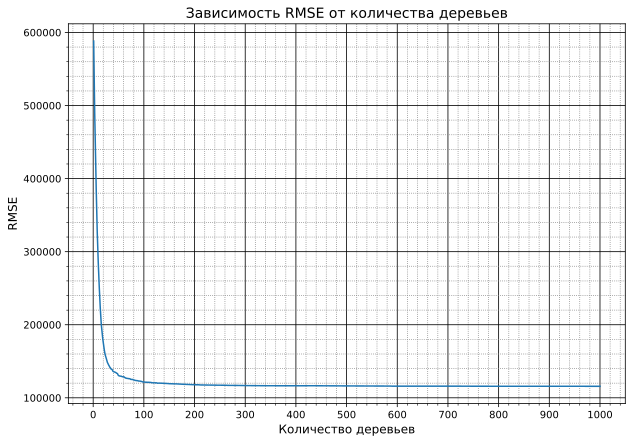

In [116]:
fig = plt.figure(figsize=(10,7))
plt.title('Зависимость RMSE от количества деревьев', fontsize=14)
plt.xlabel('Количество деревьев', fontsize=12)
plt.xticks([100 * i for i in range(11)])
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(1000) + 1, gmodel.rmse_test)
plt.savefig('GradientBoosting_trees_rmse.pdf', bbox_inches="tight")

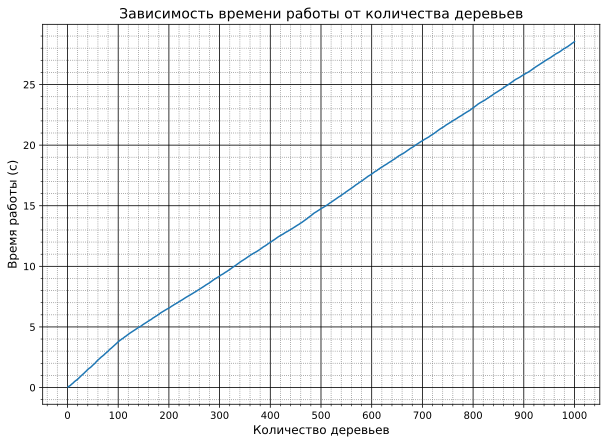

In [120]:
fig = plt.figure(figsize=(10,7))
plt.xlabel('Количество деревьев', fontsize=12)
plt.ylabel('Время работы (с)', fontsize=12)
plt.title('Зависимость времени работы от количества деревьев', fontsize=14)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.xticks([100 * i for i in range(11)])
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(1000) + 1, gmodel.time)
plt.savefig('GradientBoosting_trees_time.pdf', bbox_inches="tight")

In [122]:
rmse = []
times = []
for n_f in n_features:
    gmodel = GradientBoostingMSE(n_estimators=400, feature_subsample_size=n_f)
    gmodel.fit(X_train, y_train, X_test, y_test)
    rmse.append(gmodel.rmse_test[-1])
    times.append(gmodel.time[-1])

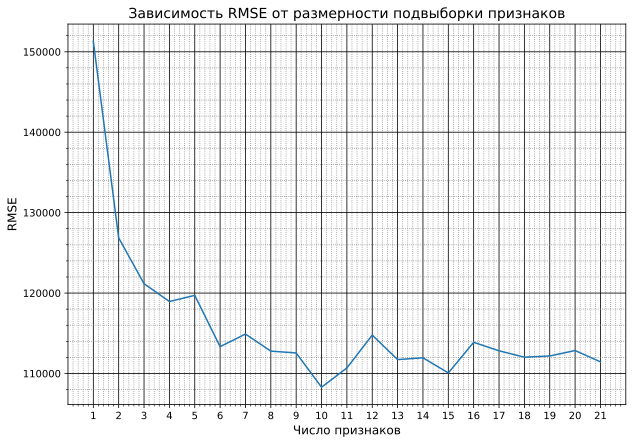

In [123]:
fig = plt.figure(figsize=(10,7))
plt.title('Зависимость RMSE от размерности подвыборки признаков', fontsize=14)
plt.xlabel('Число признаков', fontsize=12)
plt.xticks([i + 1 for i in range(21)])
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(n_features, rmse)
plt.savefig('GradientBoosting_feat_rmse.pdf', bbox_inches="tight")

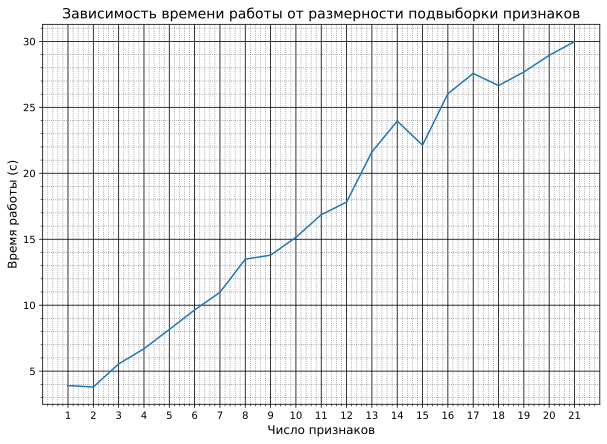

In [125]:
fig = plt.figure(figsize=(10,7))
plt.title('Зависимость времени работы от размерности подвыборки признаков', fontsize=14)
plt.xlabel('Число признаков', fontsize=12)
plt.xticks([i + 1 for i in range(21)])
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('Время работы (с)', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(n_features, times)
plt.savefig('GradientBoosting_feat_time.pdf', bbox_inches="tight")

In [130]:
depth = np.arange(20) + 1
rmse = []
times = []
for d in depth:
    gmodel = GradientBoostingMSE(n_estimators=400, feature_subsample_size=10, max_depth=d)
    gmodel.fit(X_train, y_train, X_test, y_test)
    rmse.append(gmodel.rmse_test[-1])
    times.append(gmodel.time[-1])

In [131]:
gmodel = GradientBoostingMSE(n_estimators=400, feature_subsample_size=10)
gmodel.fit(X_train, y_train, X_test, y_test)
rmse.append(gmodel.rmse_test[-1])
times.append(gmodel.time[-1])

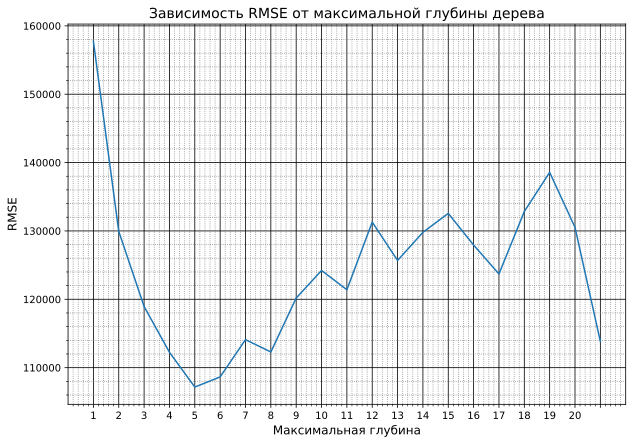

In [132]:
fig = plt.figure(figsize=(10,7))
plt.title('Зависимость RMSE от максимальной глубины дерева', fontsize=14)
plt.xlabel('Максимальная глубина', fontsize=12)
plt.xticks(ticks=(np.arange(21) + 1), labels=depth)
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(n_features, rmse)
plt.savefig('GradientBoosting_depth_rmse.pdf', bbox_inches="tight")

In [135]:
depth = list(depth)
depth.append('None')

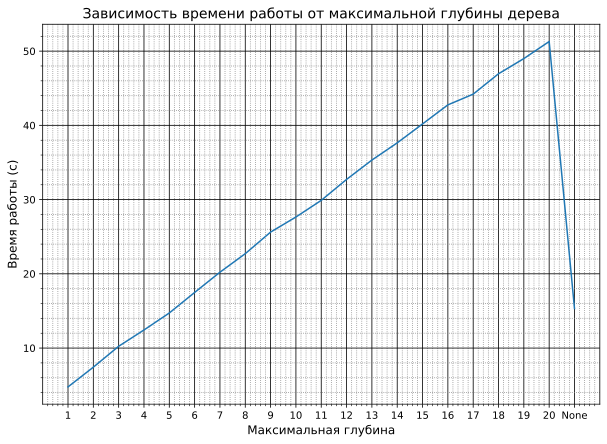

In [136]:
fig = plt.figure(figsize=(10,7))
plt.title('Зависимость времени работы от максимальной глубины дерева', fontsize=14)
plt.xlabel('Максимальная глубина', fontsize=12)
plt.xticks(ticks=(np.arange(21) + 1), labels=depth)
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('Время работы (с)', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(n_features, times)
plt.savefig('GradientBoosting_depth_time.pdf', bbox_inches="tight")

In [148]:
learn_rate = [0.01, 0.05, 0.1, 0.5, 0.75, 1]

In [149]:
rmse = []
times = []
for lr in learn_rate:
    gmodel = GradientBoostingMSE(n_estimators=400, feature_subsample_size=10, max_depth=15, learning_rate=lr)
    gmodel.fit(X_train, y_train, X_test, y_test)
    rmse.append(gmodel.rmse_test[-1])
    times.append(gmodel.time[-1])

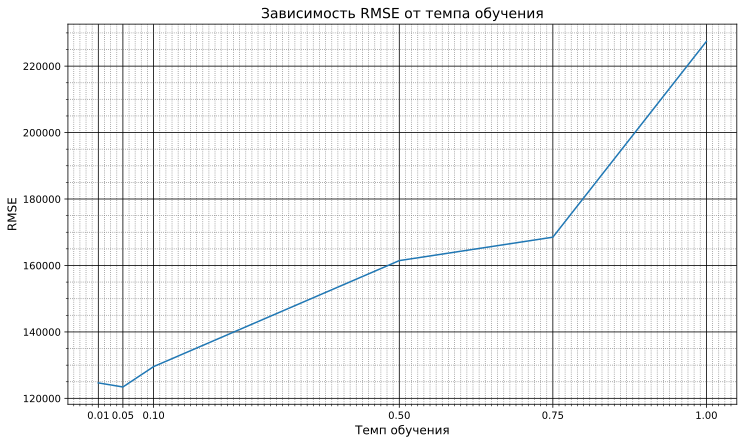

In [152]:
fig = plt.figure(figsize=(12,7))
plt.title('Зависимость RMSE от темпа обучения', fontsize=14)
plt.xlabel('Темп обучения', fontsize=12)
plt.xticks(learn_rate)
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(learn_rate, rmse)
plt.savefig('GradientBoosting_lr_rmse.pdf', bbox_inches="tight")

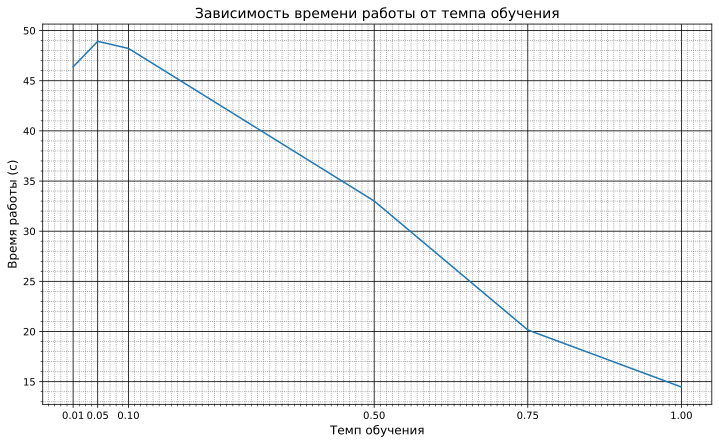

In [155]:
fig = plt.figure(figsize=(12,7))
plt.title('Зависимость времени работы от темпа обучения', fontsize=14)
plt.xlabel('Темп обучения', fontsize=12)
plt.xticks(learn_rate)
#plt.yticks([140000 + 5000 * i for i in range(20)])
plt.ylabel('Время работы (с)', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(learn_rate, times)
plt.savefig('GradientBoosting_lr_time.pdf', bbox_inches="tight")

# Сравнение

In [156]:
model = RandomForestMSE(n_estimators=200, feature_subsample_size=13, max_depth=15)
model.fit(X_train, y_train, X_test, y_test)
gmodel = GradientBoostingMSE(n_estimators=400, feature_subsample_size=10, max_depth=5, learning_rate=0.05)
gmodel.fit(X_train, y_train, X_test, y_test)
print("            RandomForest            GradientBoosting")
print("RMSE:  ", model.rmse_test[-1], "      ", gmodel.rmse_test[-1])
print("time:  ", model.time[-1], "       ", gmodel.time[-1])

            RandomForest            GradientBoosting
RMSE:   124750.21159959078        112131.29166657124
time:   28.044105529785156         15.875611066818237
